In [1]:
!nvidia-smi

Sun Apr 11 16:48:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%cd /content

/content


In [3]:
%pip install -q tensorflow-addons[tensorflow]
%pip install -q wandb

     |████████████████████████████████| 706kB 17.4MB/s 
     |████████████████████████████████| 2.1MB 21.5MB/s 
     |████████████████████████████████| 133kB 58.3MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 163kB 55.0MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 


In [4]:
!git clone https://github.com/ShivamShrirao/tiny-imagenet-test

Cloning into 'tiny-imagenet-test'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 121 (delta 70), reused 85 (delta 34), pack-reused 0
Receiving objects: 100% (121/121), 270.95 KiB | 16.93 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [5]:
%cd tiny-imagenet-test

/content/tiny-imagenet-test


In [6]:
!git pull

Already up to date.


In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import glob
import os
import csv
from tqdm.notebook import tqdm
from time import time
import random
%matplotlib inline

In [9]:
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

In [10]:
import wandb
from wandb.keras import WandbCallback

In [11]:
tf.keras.backend.set_image_data_format('channels_first')

In [12]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [15]:
train_inpds = tfds.load("imagenette/320px-v2", split='train', shuffle_files=True)
val_inpds = tfds.load("imagenette/320px-v2", split='validation')

In [16]:
BATCH_SIZE = 192
img_height, img_width = 224, 224

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

In [18]:
rng = tf.random.Generator.from_seed(123, alg='philox')
def preproc_train(inp):         # per image
    img, lbl = inp['image'], inp['label']
    img = tf.image.stateless_random_crop(img, (320, 320, 3), seed=rng.make_seeds(2)[0])
    img = img/255
    return img, lbl

def preproc_val(inp):           # per image
    img, lbl = inp['image'], inp['label']
    img = tf.image.resize(img, (320, 320))
    img = img/255
    return img, lbl

def augment(img, lbl):          # over batches
    if tf.random.uniform(shape=[]) > 0.1:
        seed = rng.make_seeds(2)[0]
        img = tf.image.stateless_random_saturation(img, 0.3, 3, seed)
        img = tf.image.stateless_random_hue(img, 0.08, seed)
        img = tf.image.stateless_random_contrast(img, 0.4, 1, seed)
        img = tf.image.stateless_random_brightness(img, 0.3, seed)
        img = tf.clip_by_value(img, 0, 1)
    return img, lbl

augmentation_layers = tf.keras.Sequential([                     # over batches
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomHeight(0.3),
    layers.experimental.preprocessing.RandomWidth(0.3),
    layers.experimental.preprocessing.RandomTranslation(0.3,0.3),
    layers.experimental.preprocessing.RandomRotation(0.15),     # 0.12 * 2pi = 43.2 deg
    layers.experimental.preprocessing.Resizing(img_height, img_width)
])
def augmentation_layers_wrapper(x, y):
    with tf.device('/device:GPU:0'):
        if tf.random.uniform(shape=[]) > 0.1:
            x, y = augmentation_layers(x, training=True), y
        return x, y

def channel_first(img, lbl):    # over batches
    with tf.device('/device:GPU:0'):
        img = tf.image.resize(img, (img_height, img_width))
        img = tf.transpose(img, perm=[0,3,1,2])
    return img, lbl

In [19]:
train_ds = (
    train_inpds
    .map(preproc_train, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .map(augmentation_layers_wrapper, num_parallel_calls=AUTOTUNE)
    .map(channel_first, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    )

In [20]:
val_ds = (
    val_inpds
    .map(preproc_val, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(channel_first, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    )

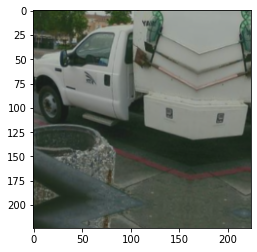

In [21]:
a, b = next(iter(train_ds))
plt.imshow(a[0].numpy().transpose(1,2,0))

In [22]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
config_defaults = {
    'activation'            : 'relu',
    'batch_size'            : BATCH_SIZE,
    'dp_rate'               : 0,
    'optimizer'             : 'adamw',
    'lr'                    : 8e-4,
    'weight_decay'          : 2e-6,
    'squeeze_reduce'        : 16,
    'loss_function'         : 'cce',
    'model'                 : 'Resnet50',
    'z_data'                : ['strides: 2,2,2,1']
}

In [25]:
run = wandb.init(project="imagenette-tests", entity="shivamshrirao", config=config_defaults)
CONFIG = wandb.config

wandb: Currently logged in as: shivamshrirao (use `wandb login --relogin` to force relogin)


In [26]:
# def ResAttnnet50(inputs=None,
#              input_shape=(3,224,224),
#              num_classes=1000,
#              dp_rate=0,
#              activation=tf.nn.relu):

#     return Resnet(AttnBottleneck, num_repeats=[3,4,6,3], inputs=inputs, input_shape=input_shape, num_classes=num_classes,
#                   dp_rate=dp_rate, activation=activation, self_attn=[False,False,True,True], nheads=8, pos_emb=True, frac_dk=1, frac_dv=1)

In [27]:
from resnet import *

In [28]:
model = Resnet50(input_shape=(3,224,224),
                 num_classes=10,
                 squeeze_reduce=CONFIG["squeeze_reduce"],
                 activation=CONFIG["activation"],
                 dp_rate=CONFIG["dp_rate"]
                 ).get_model()

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 224, 224) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 112, 112) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 56, 56)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 56, 56)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [30]:
if CONFIG["optimizer"] == 'adamw':
    opt = tfa.optimizers.AdamW(learning_rate=CONFIG["lr"], weight_decay=CONFIG["weight_decay"])
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [31]:
if CONFIG["loss_function"] == 'cce':
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

In [32]:
wandb_cb = WandbCallback(monitor='val_accuracy', mode='max', generator=val_ds)

In [33]:
model.compile(optimizer=opt, loss=loss_function, metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[wandb_cb])

Epoch 1/100
45/50 [==========================>...] - ETA: 9s - loss: 2.4628 - accuracy: 0.2640 

In [ ]:
# decisive_depth
# x = block(args)(x)
# gp = globalpool(x)
# gamma = dense(1)(gp) # sigmoid or simply relu
# next_block = block(args)
# def call(args):         # or process in batch and mask with 0
#     x, next_block, gamma = args
#     if gamma > 0.5:
#         x = next_block(x)
#     else:
#         x = pool(x) (if stride>1 else x) or pointwise(x)
# x = tf.map_fn(call, (x, next_block, gamma))
# x = block(args)(x)